<a href="https://colab.research.google.com/github/mz-zarei/CGAN_Augmentation/blob/main/SimulatedDataAugmentation_CGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1-Import Libs**

In [ ]:
import nbeb
import importlib
import numpy as np
import random
from tqdm import tqdm
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import kendalltau, pearsonr, spearmanr
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.initializers import RandomNormal
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten, BatchNormalization
from keras.layers import Conv2D, Conv1D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU, ELU, ReLU, concatenate
from keras.layers import Dropout
from matplotlib import pyplot
from keras import Input, Model
import keras
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt



def MARD(results):
    results_ = results.copy()
    results_['MARD_nb'] =  abs((results['true_rank']-results['nb_rank'])/results['true_rank'])
    mard = results_['MARD_nb'].sum()
    return mard

def FI(results):
    FI_test = 0
    for HS_level in [0.05,0.1,0.15,0.2]:
        FI_test += 1-results[(results['true_rank'] > 1- HS_level) & (results['nb_rank'] > 1- HS_level)].count()[0]/results[(results['nb_rank'] > 1- HS_level)].count()[0]
    return FI_test/4


def PMD(results):
    PMD_test = 0
    for HS_level in [0.05,0.1,0.15,0.2]:
        PMD_test += (results[results['true_rank'] > 1-HS_level]['Lambda'].mean() - results[results['nb_rank'] > 1-HS_level]['Lambda'].mean())/results[results['true_rank'] > 1-HS_level]['Lambda'].mean()
    return PMD_test/4


def rankHS(CrashData):
    results = CrashData.copy()

    results['y_pred_nb1'] = y_pred_NB1
    results['y_pred_nb2'] = y_pred_NB2
    results['alpha1'] = alpha1
    results['alpha2'] = alpha2

    results['w_nb1'] = 1/(1+results['alpha1']*results['y_pred_nb1'])
    results['EB_nb1'] = results['w_nb1']*results['y_pred_nb1'] + (1-results['w_nb1'])*results['Obs']

    results['w_nb2'] = 1/(1+results['alpha2']*results['y_pred_nb2'])
    results['EB_nb2'] = results['w_nb2']*results['y_pred_nb2'] + (1-results['w_nb2'])*results['Obs']

    results['true_rank'] =  results['Lambda'].rank(pct=True)
    results['nb1_rank'] =  results['EB_nb1'].rank(pct=True)
    results['nb2_rank'] =  results['EB_nb2'].rank(pct=True)
    return results

def eval(Concat_Data, CrashData, testData):
    results = CrashData.copy()
    y_test = test_data['Obs']
    x_test = test_data[x_columns]
    y_train = CrashData['Obs']
    y_true = CrashData['Lambda']
    x_train = CrashData[x_columns]

    significant_features = nbeb.forward_regression(Concat_Data, x_columns, y_name='Obs', threshold_in=0.05, verbose=False)

    NB_model, alpha_e  = nbeb.fitNB(Concat_Data, significant_features, y_name='Obs')

    y_test_pred_NB = NB_model.predict(sm.add_constant(x_test[significant_features]))
    y_pred_NB = NB_model.predict(sm.add_constant(CrashData[significant_features]))

    MAPE_Pred = nbeb.MAPE(y_test.to_numpy(), y_test_pred_NB)

    results['y_pred_nb'] = y_pred_NB
    results['alpha'] = alpha_e
    results['w_nb'] = 1/(1+results['alpha']*results['y_pred_nb'])
    results['EB_nb'] = results['w_nb']*results['y_pred_nb'] + (1-results['w_nb'])*results['Obs']
    results['true_rank'] =  results['Lambda'].rank(pct=True)
    results['nb_rank'] =  results['EB_nb'].rank(pct=True)

    FI_test, PMD_test, MARD_test = FI(results), PMD(results), MARD(results)
    MAPE_EB =  nbeb.MAPE(results['EB_nb'].values,results['Lambda'].values)
    MAPE_alpha = abs(alpha - alpha_e)/alpha


    return [MAPE_Pred, FI_test, PMD_test, MARD_test, MAPE_EB, MAPE_alpha], len(significant_features)






##################################################################################### GAN training Functions
# define the standalone discriminator model
def define_discriminator(in_shape=(7,)):
    y = Input(shape=(x_size,), dtype='float')
    y_output = Dense(100, activation=activation, kernel_initializer=kerner_initializer)(y)

    label = Input(shape=(1,))
    label_output = Dense(100, activation=activation, kernel_initializer=kerner_initializer)(label)

    concat = concatenate([y_output, label_output])
    concat = Dense(50, activation=activation, kernel_initializer=kerner_initializer)(concat)
    concat = Dense(50, activation=activation, kernel_initializer=kerner_initializer)(concat)
    validity = Dense(1, activation="sigmoid", kernel_initializer=random_uniform)(concat)

    model = Model(inputs=[y, label], outputs=validity)

    # compile model
    opt = Adam(learning_rate=dis_lr, beta_1=0.5, decay=dis_dec)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# define the standalone generator model
def define_generator(latent_dim, in_shape=1):
    y = Input(shape=in_shape, dtype='float')
    y_output = Dense(100, activation=activation, kernel_initializer=kerner_initializer)(y)

    noise = Input(shape=(latent_dim,))
    noise_output = Dense(100, activation=activation, kernel_initializer=kerner_initializer)(noise)

    concat = concatenate([y_output, noise_output])

    output = Dense(50, activation=activation, kernel_initializer=kerner_initializer)(concat)
    output = Dense(50, activation=activation, kernel_initializer=kerner_initializer)(output)
    output = Dense(50, activation=activation, kernel_initializer=kerner_initializer)(output)
    output = Dense(x_size, activation="relu", kernel_initializer=random_normal)(output)

    model = Model(inputs=[noise, y], outputs=output)
    return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # get noise and label inputs from generator model
    gen_noise, gen_label = g_model.input
    # get output from the generator model
    gen_output = g_model.output
    # connect output and label input from generator as inputs to discriminator
    gan_output = d_model([gen_output, gen_label])
    # define gan model as taking noise and label and outputting a classification
    model = Model([gen_noise, gen_label], gan_output)
    # compile model
    opt = Adam(learning_rate=gen_lr, beta_1=0.5, decay=gen_dec)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# load and prepare training set
def load_real_samples(x_train,y_train):

    trainX = x_train.to_numpy()
    trainY = y_train.to_numpy()

    return [trainX, trainY]

# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset[0].shape[0], n_samples)
    # retrieve selected images
    X, labels = dataset[0][ix], dataset[1][ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return [X, labels], y

# generate emipircal distribution of real y samples
def generate_y_labels(y_train, size):
    y_train = y_train.tolist()

    min_y = min(y_train)
    max_y = max(y_train)

    y_list = range(min_y, max_y+1)
    y_prob_list = []


    for y in y_list:
        y_prob = y_train.count(y)/len(y_train)
        y_prob_list.append(y_prob)

    for i, prob in enumerate(y_prob_list):
        if prob == 0:
            y_prob_list[i] = y_prob_list[len(y_prob_list)-1]
    
    y_prob_list_normalized = [float(i)/sum(y_prob_list) for i in y_prob_list]


    sample_label = np.random.choice(y_list, size=size, p=y_prob_list_normalized)
    return sample_label




# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples) #randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    idx = np.random.randint(0, x_train.shape[0], n_samples)
    labels = dataset[1][idx]
    return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    samples = generator.predict([z_input, labels_input])
    # create class labels
    y = zeros((n_samples, 1))
    return [samples, labels_input], y

# create a line plot of loss for the gan and save to file
def plot_history(d1_hist, d2_hist, g_hist):
    # plot history
    pyplot.plot(d1_hist, label='Dis loss real')
    pyplot.plot(d2_hist, label='Dis loss fake')
    pyplot.plot(g_hist, label='Gen loss')
    pyplot.legend()
    pyplot.savefig('plot_line_plot_loss.png')

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    # save the generator model tile file
    filename = '/content/drive/MyDrive/GAN_regression/ganRegression/CGAN_augment_models/generator_model_%03d.h5' % (epoch + 1)
    g_model.save(filename)

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs, n_batch):
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # lists for keeping track of loss
    d1_hist, d2_hist, g_hist = list(), list(), list()
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            # generate 'fake' examples
            [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
            # prepare points in latent space as input for the generator
            [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)

        d1_hist.append(d_loss1)
        d2_hist.append(d_loss2)
        g_hist.append(g_loss)
        # evaluate the model performance, sometimes
        if (i+1) % 500 == 0 and (i+1) > 3000:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)
            print('Epoch: %d, dLoss real = %.3f, dLoss fake = %.3f, gLoss = %.3f' % (i+1, d_loss1, d_loss2, g_loss))
    plot_history(d1_hist, d2_hist, g_hist)
    return d1_hist, d2_hist, g_hist




seed = 42
kerner_initializer = keras.initializers.he_normal(seed=seed)
random_uniform = keras.initializers.RandomUniform(seed=seed)
random_normal = keras.initializers.RandomNormal(seed=seed)
latent_dim, x_size = 4, 4
activation = "elu"



alpha, constant = 0.5, 0.5
train_size, test_size = 500, 1000

x_columns = ['X1','X2','X3','X4']
path = '/content/drive/MyDrive/GAN_regression/ganRegression/SimulatedData/AugmentData_R1_'+str(train_size)+'_'+str(alpha)+'_'+str(constant)+'.xlsx'

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **2-Simulate Test Train Crash Data**

Train size:  100  Dispersion:  0.5  mean:  1.6487212707001282


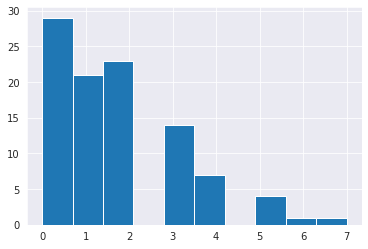

In [ ]:
alpha, constant = 0.5, 0.5
train_size, test_size = 100, 1000

path = '/content/drive/MyDrive/GAN_regression/ganRegression/SimulatedData/AugmentData_'+str(train_size)+'_'+str(alpha)+'_'+str(constant)+'.xlsx'

test_data = nbeb.simulateCrashData([0.5, -0.5, 1, -1], data_size=test_size, error_mean=1, error_var=alpha, constant=constant)
y_test = test_data['Obs']
x_test = test_data[x_columns]


CrashData = nbeb.simulateCrashData([0.5, -0.5, 1, -1], data_size=train_size, error_mean=1, error_var=alpha, constant=constant)

CrashData.to_excel(path)
print('Train size: ', train_size, ' Dispersion: ', alpha, ' mean: ', np.exp(constant))
CrashData.head()
ax = plt.hist(CrashData['Obs'])

# **3-Train GAN**

>Accuracy real: 43%, fake: 74%
Epoch: 3500, dLoss real = 0.671, dLoss fake = 0.637, gLoss = 0.791
>Accuracy real: 42%, fake: 78%
Epoch: 4000, dLoss real = 0.674, dLoss fake = 0.642, gLoss = 0.774
>Accuracy real: 31%, fake: 80%
Epoch: 4500, dLoss real = 0.668, dLoss fake = 0.645, gLoss = 0.771
>Accuracy real: 45%, fake: 82%
Epoch: 5000, dLoss real = 0.659, dLoss fake = 0.645, gLoss = 0.781


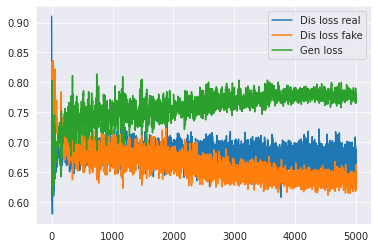

In [ ]:
CrashData = pd.read_excel(path)
y_train1 = CrashData['Obs']
x_train1 = CrashData[x_columns]


gen_lr, dis_lr, gen_dec, dis_dec, n_epochs, n_batch = 0.001, 0.001, 0.001,0, 5000, int(500)  

# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples(x_train1,y_train1)
# # train model
d1_hist, d2_hist, g_hist = train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs, n_batch)

# **4-Fit and Compare NB models**

## **Fit NB model with original data size**

In [ ]:
## NB model with train data
CrashData = pd.read_excel(path)
y_train1 = CrashData['Obs']
y_true = CrashData['Lambda']
x_train1 = CrashData[x_columns]


significant_features1 = nbeb.forward_regression(CrashData, x_columns, y_name='Obs', threshold_in=0.05, verbose=False)

NB_model1, alpha1  = nbeb.fitNB(CrashData, significant_features1, y_name='Obs')

y_test_pred_NB1 = NB_model1.predict(sm.add_constant(x_test[significant_features1]))
y_pred_NB1 = NB_model1.predict(sm.add_constant(CrashData[significant_features1]))

mae_NB1, mape_NB1, r2_NB1 = round(mean_absolute_error(y_test, y_test_pred_NB1),3), round(nbeb.MAPE(y_test.to_numpy(), y_test_pred_NB1),3), round(r2_score(y_test, y_test_pred_NB1),3)

print("Test Set  --- MAE: ", mae_NB1, "| MAPE: ", mape_NB1, "| R2 score: ", r2_NB1, " | Alpha: ", alpha1)
print(NB_model1.summary2())

Test Set  --- MAE:  1.466 | MAPE:  0.643 | R2 score:  0.111  | Alpha:  0.1678165227145116
              Results: Generalized linear model
Model:              GLM              AIC:            344.4506 
Link Function:      log              BIC:            -314.9527
Dependent Variable: Obs              Log-Likelihood: -167.23  
Date:               2021-11-05 13:30 LL-Null:        -173.68  
No. Observations:   100              Deviance:       122.54   
Df Model:           4                Pearson chi2:   104.     
Df Residuals:       95               Scale:          1.0000   
Method:             IRLS                                      
---------------------------------------------------------------
            Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
---------------------------------------------------------------
const       0.5213    0.3090   1.6868  0.0916  -0.0844   1.1270
X1          0.4712    0.3110   1.5150  0.1298  -0.1384   1.0807
X2         -0.0657    0.3180  -0.2066 

In [ ]:
x_test

,X1,X2,X3,X4
0,0.143155,0.650157,0.871292,0.231378
1,0.973441,0.167555,0.449825,0.134514
2,0.948914,0.354597,0.148333,0.586614
3,0.956807,0.782913,0.868620,0.193097
4,0.204736,0.648633,0.633695,0.725734
...,...,...,...,...
995,0.121493,0.031972,0.310045,0.921345
996,0.448746,0.189819,0.932739,0.424276
997,0.802911,0.280089,0.727293,0.684522
998,0.912462,0.813205,0.534235,0.682717


In [ ]:
CrashData

,Unnamed: 0,X1,X2,X3,X4,Obs,Lambda
0,0,0.063130,0.385756,0.067726,0.450905,2,3.398977
1,1,0.699214,0.427839,0.091114,0.718576,0,1.015068
2,2,0.059898,0.437082,0.192664,0.560023,0,0.364516
3,3,0.793303,0.976366,0.850911,0.979782,1,1.397278
4,4,0.036703,0.254901,0.675426,0.661657,2,1.648521
...,...,...,...,...,...,...,...
95,95,0.184455,0.915100,0.325106,0.170863,0,0.847078
96,96,0.400395,0.547871,0.452217,0.836919,0,0.302623
97,97,0.355540,0.402971,0.042293,0.704426,1,0.713386
98,98,0.024096,0.552591,0.016241,0.127385,0,0.896345


## **Fit NB model with CGAN augmented data size**

In [ ]:
# load GAN model
model_path = '/content/drive/MyDrive/GAN_regression/ganRegression/CGAN_augment_models/'
model = load_model(model_path + 'generator_model_9500.h5')
dataset = load_real_samples(x_train1, y_train1)

# generate samples
latent_points = generate_latent_points(latent_dim, 1000)
# generate images
Fake_data = model.predict(latent_points)
fake = pd.DataFrame(Fake_data, columns=x_columns)
fake['Obs'] = latent_points[1]


## NB model with real and fake data
# Find significant features
concat_data = pd.concat([CrashData, fake])
x_train2 = concat_data[x_columns]
y_train2 = concat_data['Obs']
significant_features2 = nbeb.forward_regression(concat_data, x_columns, y_name='Obs', threshold_in=0.05, verbose=False) 

NB_model2, alpha2 = nbeb.fitNB(concat_data, significant_features2, y_name='Obs')

y_pred_NB2 = NB_model2.predict(sm.add_constant(x_train1[significant_features2]))
y_test_pred_NB2 = NB_model2.predict(sm.add_constant(x_test[significant_features2]))


mae_NB2, mape_NB2, r2_NB2 = round(mean_absolute_error(y_test, y_test_pred_NB2),3), round(nbeb.MAPE(y_test.to_numpy(), y_test_pred_NB2),3), round(r2_score(y_test, y_test_pred_NB2),3)
print("Test Set  --- MAE: ", mae_NB2, "| MAPE: ", mape_NB2, "| R2 score: ", r2_NB2, " | Alpha: ", alpha2)

print(NB_model2.summary2())

# fake.hist(figsize=(10,8),bins=10)
# fake.describe()

Test Set  --- MAE:  1.425 | MAPE:  0.644 | R2 score:  0.119  | Alpha:  0.15419832396119068
               Results: Generalized linear model
Model:              GLM              AIC:            4671.7167 
Link Function:      log              BIC:            -9167.9133
Dependent Variable: Obs              Log-Likelihood: -2330.9   
Date:               2021-11-05 13:23 LL-Null:        -2917.8   
No. Observations:   1500             Deviance:       1765.4    
Df Model:           4                Pearson chi2:   1.95e+03  
Df Residuals:       1495             Scale:          1.0000    
Method:             IRLS                                       
----------------------------------------------------------------
            Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
----------------------------------------------------------------
const       0.8941    0.1104    8.0959  0.0000   0.6777   1.1106
X4         -1.8308    0.0802  -22.8351  0.0000  -1.9879  -1.6736
X3          0.9404    0

## **Compare each NB model for NS results**

In [ ]:

results = rankHS(CrashData)
hotspot_percentage = np.arange(0.01,0.21,0.01)


res = []
for i in hotspot_percentage:
    FI_nb1, FI_nb2, FI_change = FI(results,i)
    PMD_nb1, PMD_nb2, PMD_change = PMD(results,i)
    MAPE_nb1, MAPE_nb2, MAPE_change = MAPE_h(results,i)
    # print(round(i*100,2) , '% hotspotts')
    # print('FI: nb1=%.3f, nb2=%.3f' % (FI_nb1,FI_nb2))
    # print('PMD: nb1=%.3f, nb2=%.3f' % (PMD_nb1,PMD_nb2))

    res.append([FI_nb1, FI_nb2,FI_change, PMD_nb1, PMD_nb2,PMD_change, MAPE_nb1, MAPE_nb2,MAPE_change])
    
    print('FI  improvement: ', FI_change)
    print('PMD MAE improvement: ', PMD_change)
    print("="*50)

res = pd.DataFrame(res, columns=["FI_nb1", "FI_nb2", "FI_change", "PMD_nb1", "PMD_nb2", "PMD_change", "MAPE_nb1", "MAPE_nb2", "MAPE_change"])

print(' MAE: nb1=%.3f, nb2=%.3f' % (round(mean_absolute_error(results['EB_nb1'],results['Lambda']),3),round(mean_absolute_error(results['EB_nb2'],results['Lambda']),3)))
print('MAPE: nb1=%.3f, nb2=%.3f' % (round(nbeb.MAPE(results['EB_nb1'],results['Lambda']),3),round(nbeb.MAPE(results['EB_nb2'],results['Lambda']),3)))
print('  R2: nb1=%.3f, nb2=%.3f' % (round(r2_score(results['EB_nb1'],results['Lambda']),3),round(r2_score(results['EB_nb2'],results['Lambda']),3)))

fig, ax = plt.subplots(1,3,figsize=(15,4))

ax[0].plot(res.index+1, res["FI_nb1"], label='FI_nb1', marker = "s")
ax[0].plot(res.index+1, res["FI_nb2"], label='FI_nb2', marker = "o")
ax[0].legend(loc="lower right")
ax[0].set_xlabel('HS%')

ax[1].plot(res.index+1, res["PMD_nb1"], label='PMD_nb1', marker ="s")
ax[1].plot(res.index+1, res["PMD_nb2"], label='PMD_nb2',marker = "o")
ax[1].legend(loc="lower right")
ax[1].set_xlabel('HS%')

ax[2].plot(res.index+1, res["MAPE_nb1"], label='MAPE_nb1', marker = "s")
ax[2].plot(res.index+1, res["MAPE_nb2"], label='MAPE_nb2', marker = "o")
ax[2].legend(loc="lower right")
ax[2].set_xlabel('HS%')

plt.show()
res.describe()

TypeError: ignored

# **5-Replications**

In [ ]:
tests = []
constant = 0.5
train_size, test_size = 100, 1000

for alpha in [0.5, 1.5]:
    for i in tqdm(range(1000)):
        ## Simulate new validation data
        test_data = nbeb.simulateCrashData([0.5, -0.5, 1, -1], data_size=test_size, error_mean=1, error_var=alpha, constant=constant)
        CrashData = nbeb.simulateCrashData([0.5, -0.5, 1, -1], data_size=train_size, error_mean=1, error_var=alpha, constant=constant)

        y_train = CrashData['Obs']
        x_train = CrashData[x_columns]

        ## Generate Fake data
        # load GAN model
        model = load_model('/content/drive/MyDrive/GAN_regression/ganRegression/CGAN_augment_models/generator_model_'+str(train_size)+'_'+str(alpha)+'_'+str(constant)+'.h5', compile=False)
        dataset = load_real_samples(x_train, y_train)
        # generate samples
        latent_points = generate_latent_points(latent_dim, 1000)
        Fake_data = model.predict(latent_points)
        fake = pd.DataFrame(Fake_data, columns=x_columns)
        fake['Obs'] = latent_points[1]


        ## Evaluation results
        for fake_size in [0, 200, 500, 1000]:
            eval_list = []
            eval_list.append(fake_size)
            eval_list.append(alpha)
            Concat_data = pd.concat([CrashData, fake.sample(fake_size)])
            eval_results, sig_fit = eval(Concat_data, CrashData, test_data)
            
            eval_list.extend(eval_results)
            if fake_size == 0:
                sig_fit0 = sig_fit
            
            eval_list.append(sig_fit0)

            tests.append(eval_list)


100%|██████████| 1000/1000 [29:58<00:00,  1.80s/it]


In [ ]:
tests = pd.DataFrame(tests, columns=["Synthetic Data Size", "Dispersion", "MAPE(test)", "FI", "PMD", "MARD", "MAPE(EB)", "MAPE(alpha)", "Significant Features"])
tests.to_excel('Results_'+str(train_size)+'.xlsx')

# **6-Plots**

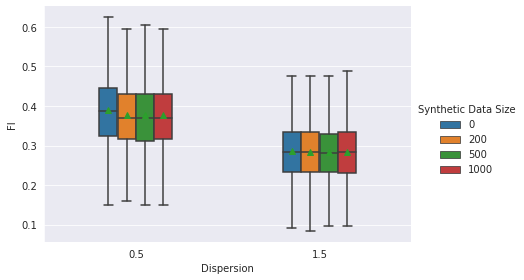

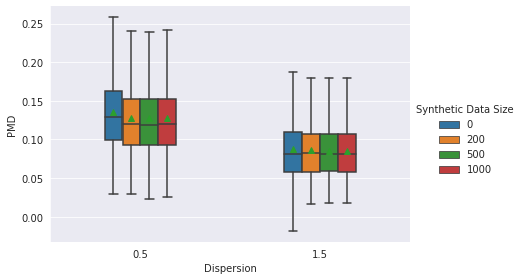

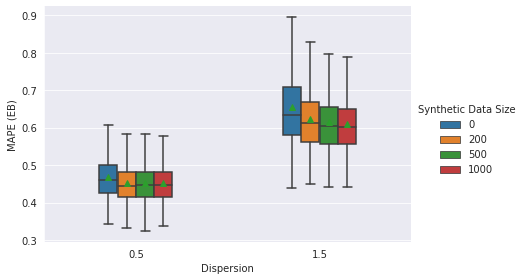

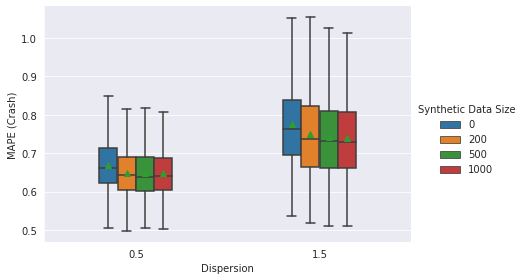

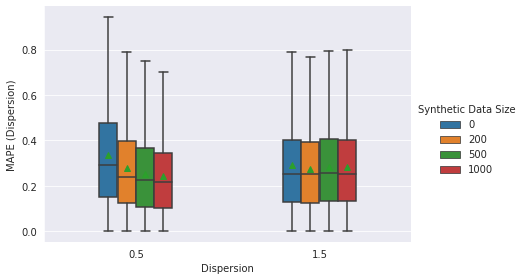

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

tests = pd.read_excel('/content/Results_100.xlsx')
sns.set_style("darkgrid")

s = sns.catplot(data=tests, x="Dispersion", y = "FI", hue="Synthetic Data Size", width=0.4, kind="box", height=4, aspect=1.5, showfliers=False, showmeans =True)
plt.show()
s.savefig('FI.pdf')

s = sns.catplot(data=tests, x="Dispersion", y = "PMD", hue="Synthetic Data Size", width=0.4,  kind="box", height=4, aspect=1.5, showfliers=False, showmeans =True)
plt.show()
s.savefig('PMD.pdf')

s = sns.catplot(data=tests, x="Dispersion", y = "MAPE (EB)", hue="Synthetic Data Size", width=0.4, kind="box", height=4, aspect=1.5, showfliers=False, showmeans =True)
plt.show()
s.savefig('EB.pdf')

s = sns.catplot(data=tests, x="Dispersion", y = "MAPE (Crash)", hue="Synthetic Data Size", width=0.4,  kind="box", height=4, aspect=1.5, showfliers=False, showmeans =True)
plt.show()
s.savefig('Crash.pdf')

s = sns.catplot(data=tests, x="Dispersion", y = "MAPE (Dispersion)", hue="Synthetic Data Size", width=0.4,  kind="box", height=4, aspect=1.5, showfliers=False, showmeans =True)
plt.show()
s.savefig('Dispersion.pdf')



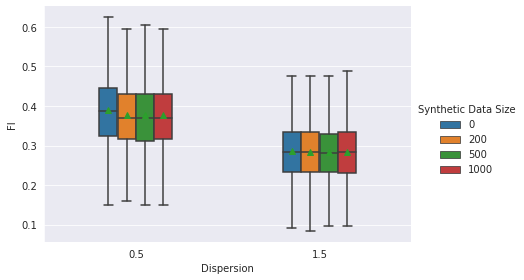

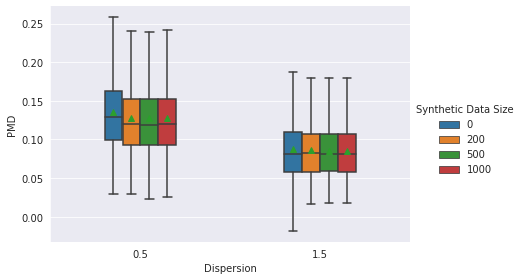

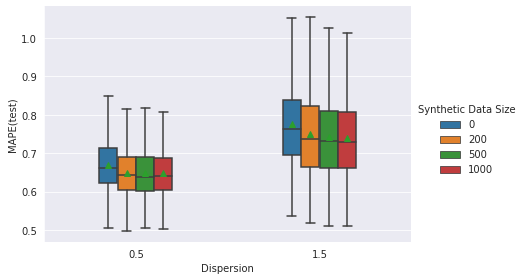

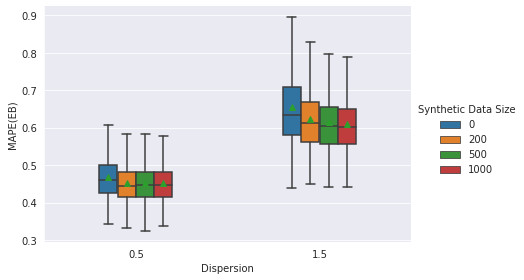

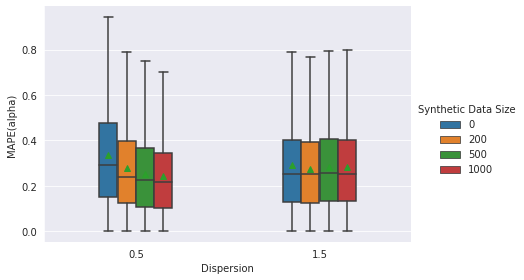

In [ ]:
sns.catplot(data=tests, x="Dispersion", y = "FI", hue="Synthetic Data Size", width=0.4, kind="box", height=4, aspect=1.5, showfliers=False, showmeans =True)
sns.catplot(data=tests, x="Dispersion", y = "PMD", hue="Synthetic Data Size", width=0.4, kind="box", height=4, aspect=1.5, showfliers=False, showmeans =True)
sns.catplot(data=tests, x="Dispersion", y = "MAPE(test)", hue="Synthetic Data Size", width=0.4, kind="box", height=4, aspect=1.5, showfliers=False, showmeans =True)
sns.catplot(data=tests, x="Dispersion", y = "MAPE(EB)", hue="Synthetic Data Size", width=0.4, kind="box", height=4, aspect=1.5, showfliers=False, showmeans =True)
sns.catplot(data=tests, x="Dispersion", y = "MAPE(alpha)", hue="Synthetic Data Size", width=0.4, kind="box", height=4, aspect=1.5, showfliers=False, showmeans =True)
